Credit: *Axel Guinot* for all simulations from `descwl_shear_sims`, *Ismael Mendoza* functions for HMC using `jax_galsim`.

# Setup

In [110]:
import numpy as np

import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom
from descwl_shear_sims.galaxies import make_galaxy_catalog
from descwl_shear_sims.psfs import make_fixed_psf
from descwl_shear_sims.sim import make_sim
from descwl_shear_sims.objlists import get_objlist
from descwl_shear_sims.surveys import get_survey
from descwl_shear_sims.constants import FIXED_PSF_FWHM, SCALE

import metadetect

import matplotlib.pyplot as plt

import galsim

import gc

In [111]:
import numpy as np
import descwl_shear_sims
import lsst.afw
import matplotlib.pyplot as plt 

# Working in float64
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jax_galsim as galaxim

In [112]:
jax.devices()

[gpu(id=0)]

In [113]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random

In [114]:
def get_coadd_center_gs_pos(coadd_wcs, coadd_bbox):
    """
    get the sky position of the center of the coadd within the
    bbox as a galsim CelestialCoord

    Parameters
    ----------
    coadd_wcs: DM wcs
        The wcs for the coadd
    coadd_bbox: geom.Box2I
        The bounding box for the coadd within larger wcs system

    Returns
    -------
    galsim CelestialCoord
    """

    # world origin is at center of the coadd, which itself
    # is in a bbox shifted from the overall WORLD_ORIGIN

    bbox_cen_skypos = coadd_wcs.pixelToSky(
        coadd_bbox.getCenter()
    )

    return galsim.CelestialCoord(
        ra=float(bbox_cen_skypos.getRa()) * galsim.radians,
        dec=float(bbox_cen_skypos.getDec()) * galsim.radians,
)

## Setup data

In [140]:
seed = 8312
rng = np.random.RandomState(seed)
COADD_DIM = 251
N_OBJECTS = 25
# COADD_DIM = 231
# N_OBJECTS = 16
# COADD_DIM = 201
# N_OBJECTS = 4
PSF_DIM = 51
bands = ['i']
NOISE_FACTOR = 1e-3

# this makes a grid of fixed exponential galaxies
# with default properties. One exposure per band

galaxy_catalog = make_galaxy_catalog(
    rng=rng,
    gal_type='fixed',
    coadd_dim=COADD_DIM,
    buff=30,
    layout='grid',
    gal_config={"morph": "exp", "mag": 20}
)
survey = get_survey(gal_type=galaxy_catalog.gal_type, band=bands[0])
noise_for_gsparams = survey.noise*NOISE_FACTOR
lists = get_objlist(
    galaxy_catalog=galaxy_catalog,
    survey=survey,
    star_catalog=None,
    noise=noise_for_gsparams,
)
# gaussian psf
psf = make_fixed_psf(psf_type='gauss')

In [141]:
lists['objlist'][0].half_light_radius, lists['objlist'][0].flux,

(0.5, 10000.0)

In [142]:
data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=COADD_DIM,
    psf_dim=PSF_DIM,
    bands=bands,
    g1=0.02,
    g2=0.00,
    psf=psf,
    dither=False,
    rotate=False,
    se_dim=COADD_DIM,
    noise_factor=NOISE_FACTOR,
)


In [143]:
se_wcs = data['se_wcs'][0]
coadd_gs_center = get_coadd_center_gs_pos(data['coadd_wcs'], data['coadd_bbox'])
obj_x = []
obj_y = []
for shift in lists['shifts']:
    shift = shift.shear(galsim.Shear(g1=0.02, g2=0.))
    w_pos = coadd_gs_center.deproject(shift.x*galsim.arcsec, shift.y*galsim.arcsec)
    image_pos = se_wcs.toImage(w_pos)
    obj_x.append(image_pos.x)
    obj_y.append(image_pos.y)
obj_x = np.array(obj_x)
obj_y = np.array(obj_y)

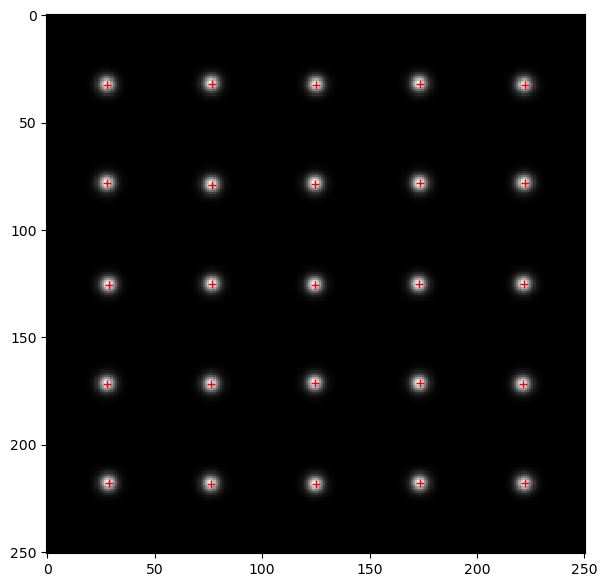

In [144]:
plt.figure(figsize=(7, 7))
plt.imshow(data['band_data']['i'][0].image.array, cmap='gray', interpolation='nearest')
plt.plot(obj_x-1, obj_y-1, 'r+')
plt.show()

In [145]:
def _coadd_sim_data(rng, sim_data, nowarp, remove_poisson):
    """
    copied from mdet-lsst-sim
    """
    from descwl_coadd.coadd import make_coadd
    from descwl_coadd.coadd_nowarp import make_coadd_nowarp
    from metadetect.lsst.util import extract_multiband_coadd_data

    bands = list(sim_data['band_data'].keys())

    if nowarp:
        exps = sim_data['band_data'][bands[0]]

        if len(exps) > 1:
            raise ValueError('only one epoch for nowarp')

        coadd_data_list = [
            make_coadd_nowarp(
                exp=exps[0],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    else:
        coadd_data_list = [
            make_coadd(
                exps=sim_data['band_data'][band],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                coadd_wcs=sim_data['coadd_wcs'],
                coadd_bbox=sim_data['coadd_bbox'],
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    return extract_multiband_coadd_data(coadd_data_list)

In [146]:
def get_psf(exp):

    from metadetect.lsst.util import get_integer_center

    wcs = exp.getWcs()
    bbox = exp.getBBox()

    # this is to be consistent with the coadd code
    cen, _ = get_integer_center(
        wcs=wcs,
        bbox=bbox,
        as_double=True,
    )
    cen_gs = galsim.PositionD(x=cen.x, y=cen.y)

    psf_obj = exp.getPsf()
    psf_image = psf_obj.computeKernelImage(cen).array

    coadd_wcs = make_coadd_wcs(wcs, bbox)

    psf_gs = galsim.InterpolatedImage(
        galsim.Image(psf_image, wcs=coadd_wcs)
    )

    local_wcs = coadd_wcs.local(cen_gs)

    pixel = local_wcs.toWorld(galsim.Pixel(scale=1))
    pixel_inv = galsim.Deconvolve(pixel)

    psf_gs_no_pixel = galsim.Convolve([psf_gs, pixel_inv])

    return psf_gs_no_pixel

In [147]:
data

{'band_data': {'i': [<lsst.afw.image._exposure.ExposureF at 0x7f5df01670b0>]},
 'coadd_wcs': FITS standard SkyWcs:
 Sky Origin: (200.0000000000, +0.0000000000)
 Pixel Origin: (1624, 1624)
 Pixel Scale: 0.2 arcsec/pixel,
 'psf_dims': (51, 51),
 'coadd_dims': (251, 251),
 'coadd_bbox': Box2I(corner=Point2I(1000, 450), dimensions=Extent2I(251, 251)),
 'bright_info': array([], dtype=int64),
 'se_wcs': [galsim.GSFitsWCS(_data = ['TAN', array([126.0, 126.0]), array([[-5.5555555555555565e-05, -0.0], [0.0, 5.5555555555555565e-05]]), coord.CelestialCoord(coord.Angle(3.4911423480046486, coord.radians), coord.Angle(-0.0010171386331415655, coord.radians)), None, None, None])]}

In [148]:
mb_coadd = _coadd_sim_data(np.random.RandomState(42), data, True, False)

INFO:descwl_coadd.coadd_nowarp:making coadd obs


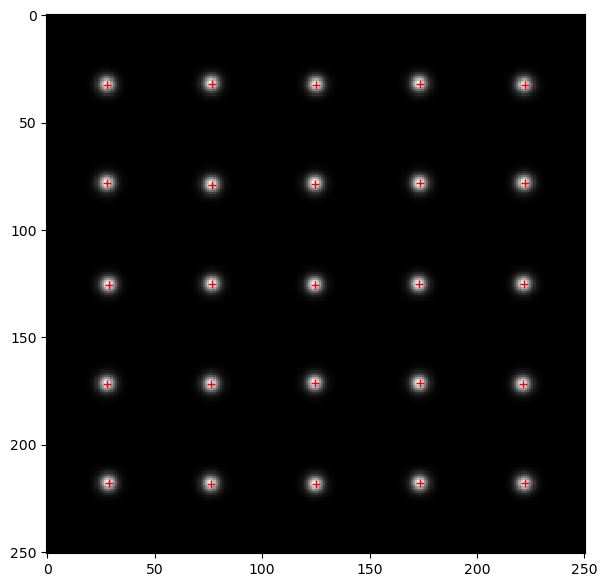

In [149]:
plt.figure(figsize=(7, 7))
plt.imshow(mb_coadd['mbexp']['i'].image.array, cmap='gray', interpolation='nearest')
plt.plot(obj_x-1, obj_y-1, 'r+')
#plt.plot(lists['shifts'][0].x, lists['shifts'][0].y, 'g+')
plt.show()

# Model and Inference

In [150]:
def make_coadd_wcs(coadd_dm_wcs, coadd_dm_bbox):
    """
    make and return a wcs object

    NOTE: copy of make_wcs

    Parameters
    ----------

    Returns
    -------
    A galsim wcs object, currently a TanWCS
    """

    scale = coadd_dm_wcs.getPixelScale().asArcseconds()

    w_orig = coadd_dm_wcs.getSkyOrigin()
    ra = w_orig.getRa().asDegrees()
    dec = w_orig.getDec().asDegrees()
    world_origin = galsim.CelestialCoord(
        ra=ra*galsim.degrees,
        dec=dec*galsim.degrees,
    )

    coadd_dims = [coadd_dm_bbox.height, coadd_dm_bbox.width]
    coadd_cen = (np.array(coadd_dims)-1)/2
    image_origin = galsim.PositionD(x=coadd_cen[1], y=coadd_cen[0])
    

    mat = np.array(
        [[scale, 0.0],
         [0.0, scale]],
    )

    return galsim.TanWCS(
        affine=galsim.AffineTransform(
            mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1],
            origin=image_origin,
        ),
        world_origin=world_origin,
        units=galsim.arcsec,
    )

In [151]:
coadd_img = mb_coadd['mbexp']['i'].image.array
# psf_gs_no_pix = get_psf(mb_coadd['mbexp']['i'])
psf_gs_no_pix = galaxim.Gaussian(fwhm=FIXED_PSF_FWHM)
# coadd_img = data['band_data']['i'][0].image.array
inv_var = 1.  # /data['band_data']['i'][0].variance.array
POS = np.array([obj_x, obj_y]).T
coadd_wcs = data['coadd_wcs']
coadd_bbox = data['coadd_bbox']

In [152]:
# coadd metadata setup
COADD_WCS = make_coadd_wcs(coadd_wcs, coadd_bbox)

In [153]:
lists['shifts']

[galsim.PositionD(x=-19.060483545200228, y=-18.92722929308928),
 galsim.PositionD(x=-19.061784253615148, y=-9.566506452998848),
 galsim.PositionD(x=-18.91085328599825, y=0.09173555652293267),
 galsim.PositionD(x=-19.053215180604507, y=9.4930303513979),
 galsim.PositionD(x=-18.926431045206023, y=18.92465399678729),
 galsim.PositionD(x=-9.51974441140952, y=-19.023891649390542),
 galsim.PositionD(x=-9.493534453836556, y=-9.415016831288348),
 galsim.PositionD(x=-9.466598140070538, y=0.010260494171252566),
 galsim.PositionD(x=-9.535153783270587, y=9.51456426701614),
 galsim.PositionD(x=-9.57474745093526, y=18.977999265255754),
 galsim.PositionD(x=0.044136041705699694, y=-18.92379788016691),
 galsim.PositionD(x=-0.06173634590267623, y=-9.519901154019495),
 galsim.PositionD(x=-0.09202468678745378, y=0.09988232914723089),
 galsim.PositionD(x=-0.07767326992763866, y=9.42123156339738),
 galsim.PositionD(x=-0.02319628541348917, y=19.037614802896716),
 galsim.PositionD(x=9.48274514162135, y=-19.01

In [154]:
# 
# PSF = galaxim.Gaussian(fwhm=FIXED_PSF_FWHM)
# SHIFTS = [s.shear(galsim.Shear(g1=0.02,g2=0.))/SCALE for s in lists['shifts']]

# @jax.jit
# def draw_gal(x, y, hlr, f, g1, g2):
#     pos = galaxim.PositionD(x=x,y=y)
#     gal = galaxim.Exponential(flux = flux, half_light_radius=hlr)
#     gal = gal.shear(g1=g1, g2=g2)
#     obj = galaxim.Convolve([gal, psf_gs_no_pix]).withGSParams(GSPARAMS)
#     return obj.drawImage(nx=COADD_DIM, ny=COADD_DIM, offset=image_pos, scale=SCALE)
    

# @jax.jit
# def draw_model(x_shifts, y_shifts, hlrs, fluxes, g1, g2):
#     x = jnp.array([s.x - x_shifts[ii] for ii,s in enumerate(SHIFTS)])
#     y = jnp.array([s.y - y_shifts[ii] for ii,s in enumerate(SHIFTS)])
#     stamps = draw_gal(x, y, hlrs, fluxes, g1, g2)

        


#         image += stamp
        
        
#     return image.array

In [155]:
GSPARAMS = galaxim.GSParams(minimum_fft_size=512, maximum_fft_size=512)

@jax.jit
def draw_model(xs, ys, hlrs, fluxes, g1, g2):

    psf_gs_no_pix = galaxim.Gaussian(fwhm=FIXED_PSF_FWHM)
    image = galaxim.Image(COADD_DIM, COADD_DIM, scale=SCALE)
    for ii in range(N_OBJECTS):
        shift = lists['shifts'][ii]#arcsec 
        shift = shift.shear(galsim.Shear(g1=0.02, g2=0.))
        pos = shift / SCALE
        
        pos = galaxim.PositionD(pos.x, pos.y)
        x = xs[ii]
        y = ys[ii]
        hlr = hlrs[ii]
        flux = fluxes[ii]

        shift = galaxim.PositionD(x=x,y=y)
        image_pos = pos - shift
        gal = galaxim.Exponential(flux = flux, half_light_radius=hlr)
        gal = gal.shear(g1=g1, g2=g2)

        obj = galaxim.Convolve([gal, psf_gs_no_pix]).withGSParams(GSPARAMS)
        stamp = obj.drawImage(nx=COADD_DIM, ny=COADD_DIM, offset=image_pos, scale=SCALE)
        image += stamp
        
        
    return image.array

In [156]:
def prob_model(y=None):
    g1 = numpyro.sample('g1', dist.Uniform(-0.05, 0.05))
    g2 = numpyro.sample('g2', dist.Uniform(-0.05, 0.05))
    with numpyro.plate('gals', N_OBJECTS, dim=-1):
        fluxes = 10**numpyro.sample('f', dist.Uniform(3.5, 4.5))
        hlrs = numpyro.sample('hlr', dist.Uniform(0.3, 0.8))
        xs = numpyro.sample('x', dist.Uniform(-0.5, 0.5))
        ys = numpyro.sample('y', dist.Uniform(-0.5, 0.5))
    im = draw_model(xs, ys, hlrs, fluxes, g1, g2)
    numpyro.sample('obs', dist.Normal(im, 1.), obs=y)

In [157]:
TRUTH_IMAGE = mb_coadd['mbexp']['i'].image.array

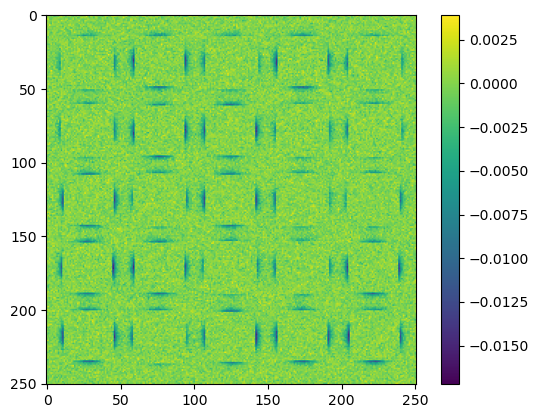

In [161]:
# truth check? 
xs = jnp.zeros(N_OBJECTS)
ys = jnp.zeros(N_OBJECTS)
hlrs = jnp.array([0.5]*N_OBJECTS)
fluxes = jnp.array([lists['objlist'][0].flux]*N_OBJECTS)
g1 = jnp.array([0.02])
g2 = jnp.array([0.00])
arr = draw_model(xs, ys, hlrs, fluxes, g1, g2)
plt.imshow(TRUTH_IMAGE - arr)

# fig, axes = plt.subplots(1, 3, figsize=(11, 5))
# axes[0].imshow(TRUTH_IMAGE)
# axes[1].imshow(arr)
# axes[2].imshow(TRUTH_IMAGE - arr)

# axes[0].plot(obj_x-1, obj_y-1, 'r+')
# axes[1].plot(obj_x-1, obj_y-1, 'r+')
plt.colorbar()

In [163]:
nuts_kernel = NUTS(prob_model, max_tree_depth=10) 
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000)
rng_key = random.PRNGKey(2)
mcmc.run(rng_key, y=TRUTH_IMAGE)

sample: 100%|██████████| 4000/4000 [08:01<00:00,  8.31it/s, 15 steps of size 2.63e-01. acc. prob=0.84]   


In [164]:
mcmc.get_samples().keys()

dict_keys(['f', 'g1', 'g2', 'hlr', 'x', 'y'])

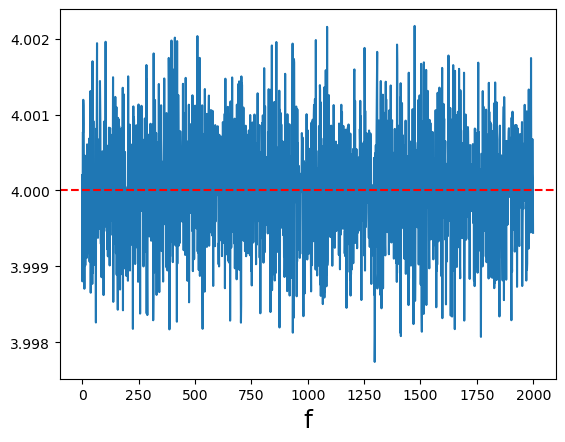

In [185]:
plt.plot(mcmc.get_samples()['f'][:, 1])
plt.xlabel('f', fontsize=18)
plt.axhline(4, color='r', ls='--')

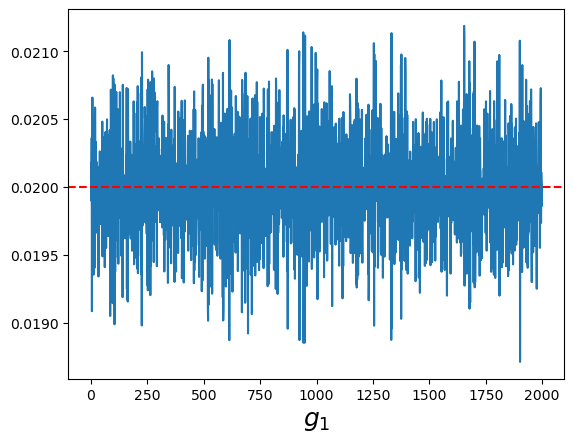

In [165]:
plt.plot(mcmc.get_samples()['g1'])
plt.xlabel('$g_1$', fontsize=18)
plt.axhline(0.02, color='r', ls='--')

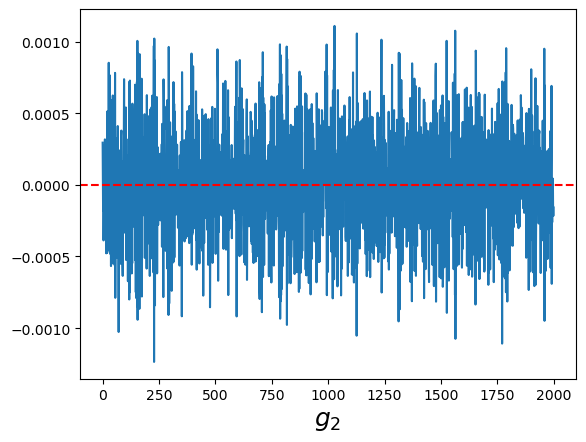

In [166]:
plt.plot(mcmc.get_samples()['g2'])
plt.xlabel('$g_2$', fontsize=18)
plt.axhline(0.00, color='r', ls='--')

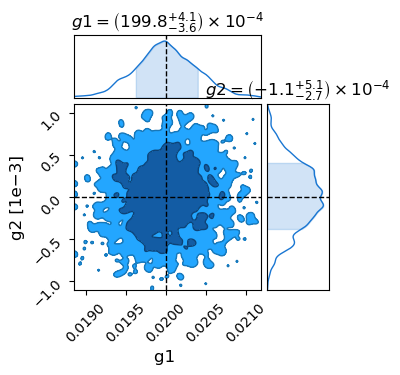

In [167]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
res = mcmc.get_samples()
c.add_chain(
    {k:res[k] for k in ['g1', 'g2']},
    name='Posterior'
)
fig = c.plotter.plot(truth={'g1':0.02, 'g2':0.0})